# Dynamic circuits

In [4]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.result import marginal_counts
from qiskit.visualization import *
from qiskit_aer import AerSimulator, Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
import numpy as np
from IPython.display import Image
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore')

with open('../../api_key.txt', 'r') as file:
    token = file.read()

print(f"Environment initialized with token: \n{token}")

Environment initialized with token: 
90981bf5634c68f2a1d96b5142dfe62128ab5a08d8450857f579ecc6821677822379b5dea66099ce1bc4a1d683642cd81a8fb5806f9a6a1f38527d455720ec4f


**Dynamic circuits** are quantum circuits that contain mid-circuit measurements where the results of those measurements are used to condition quantum gates later in the circuit. The ability to condition future quantum operations on the classical measurement results is known as classical feedforward.

Dynamic circuits are quantum circuits that include control flow such as if statements and while loops

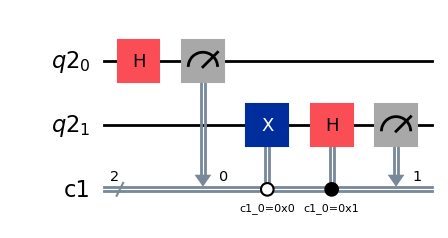

In [5]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)

# Create a dynamic circuit that:
# 1) applies an x gate to q1 if the bit 0 is 0
# 1) applies an h gate to q1 if the bit 0 is 1

# Your code goes here:
qc.measure(q0,b0)
qc.x(q1).c_if(b0,0)
qc.h(q1).c_if(b0,1)

qc.measure(q1,b1)
qc.draw("mpl")

**Question:**

Considering the circuit above:

What are (roughly) the expected counts for the $|00\rangle$, $|01\rangle$, $|10\rangle$, $|11\rangle$ states?

In [6]:
aer_backend = AerSimulator()

In [7]:
# Execute the dynamic circuit (qc) on a local backend. Extract the counts.
service = QiskitRuntimeService(channel='ibm_quantum',token=token)
real_backend = service.backend('ibm_brisbane')
fake_backend = AerSimulator.from_backend(real_backend)
fake_backend

AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['ecr', 'id', 'sx', 'measure', 'reset', 'x']>)

Transpile to ISA

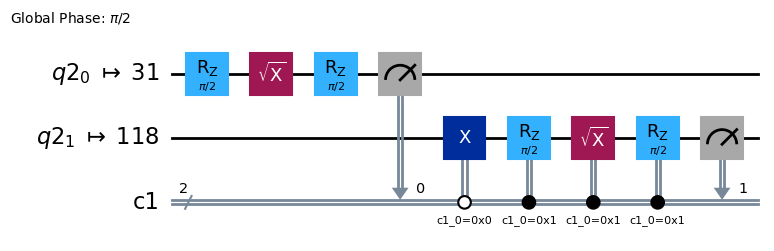

In [8]:
pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=3)
isa_qc = pm.run(qc)
isa_qc.draw("mpl",idle_wires=False)

In [9]:
aer_sampler = AerSampler()
result = aer_sampler.run([isa_qc]).result()

In [10]:
counts = result.quasi_dists
counts

[{3: 0.24609375, 2: 0.50390625, 1: 0.25}]

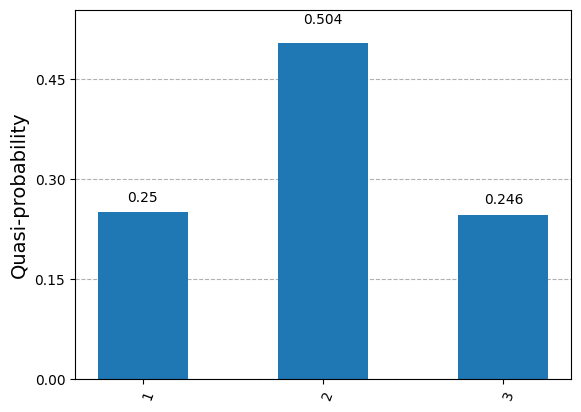

In [11]:
plot_histogram(counts)

Note that the bar lables correspond to the binary representation of the states 
* 1 -> |01>
* 2 -> |10>
* 3 -> |11>

## Quantum Teleportation


Alice possesses a qubit in an unknown state $\lvert \psi \rangle$ and she wishes to transfer this quantum state to Bob. She can not simply clone or copy the state, but she can transfer the her qubit state to Bob.

By sending two bits of classical information Bob will at the end possess $\lvert \psi \rangle$, and Alice will no longer have it. This is known as teleportation.

The protocol requires three qubits:

1. The qubit to be teleported (Alice's qubit)
2. One half of an entangled pair of qubits (Alice's second qubit)
3. The other half of the entangled pair (Bob's qubit)

The protocol can be summarized in the following steps:

1. Create an entangled pair of qubits (Bell pair) shared between Alice and Bob.
2. Alice performs a Bell basis measurement on her two qubits.
3. Alice sends the classical results of her measurement to Bob.
4. Bob applies appropriate quantum gates based on Alice's measurement results to obtain the teleported state.

In [14]:
# Image(filename='images/quantum_teleportation.jpeg') 

In [22]:
qr = QuantumRegister(3, name="q")
cr = ClassicalRegister(3, name="c")
s, a, b = qr
c0, c1, c2 = cr

In [15]:
def create_bell_pair(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    """Creates a bell pair between qubits a and b."""
    qc = QuantumCircuit(qr, cr)
    # the first qubit is s but we won't be using it in this exercise
    s, a, b = qr
    # Create a bell pair between alice and bob.
    
    # Your code goes here:
    qc.h(a)
    qc.cx(a,b)
    
    return qc

In [16]:
def alice_gates(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    """Creates Alices's gates"""
    qc = QuantumCircuit(qr, cr)
    s, a, b = qr
    # Perform a bell basis measurement on alices qubits (s,a)
    qc.cx(s,a)
    qc.h(s)
    return qc

In [17]:
def measure_and_send(qr: QuantumRegister, cr: ClassicalRegister):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc = QuantumCircuit(qr, cr)
    s, a, b = qr
    c0, c1, c2 = cr
    qc.measure([a,s],[c0,c1])
    return qc

In [19]:
def bob_gates(qr: QuantumRegister, cr: ClassicalRegister):
    """Uses qc.if_test to control which gates are dynamically added"""
    s, a, b = qr
    c0, c1, c2 = cr
    # If the bits are `00`, no action is required.
    # If they are `01`, an 𝑋 gate (also known as a Pauli-X or a bit-flip gate) should be applied.
    # For bits `10`, a 𝑍 gate (also known as a Pauli-Z or a phase-flip gate) should be applied. 
    # Lastly, if the classical bits are `11`, a combined 𝑍𝑋 sequence should be applied.

    # Your code goes here:
    qc.z(b).c_if(c0,1)
    qc.x(b).c_if(c1,1)
    
    
    return qc

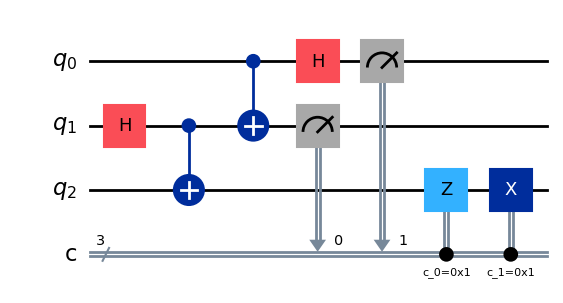

In [49]:
# Compose a circuit (inplace) with the name 'teleport' that incorporates the following steps:
# 1) create a bell pair
# 2) apply alices gates
# 3) measure and send
# 4) apply bobs gates
# 5) measure

# Your code goes here:
teleport = create_bell_pair(qr,cr)
teleport = teleport.compose(alice_gates(qr,cr))
teleport = teleport.compose(measure_and_send(qr,cr))
teleport = teleport.compose(bob_gates(qr,cr))
teleport.draw("mpl")


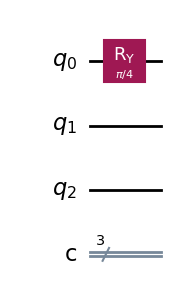

In [50]:
# define source qubit
source = QuantumCircuit(qr,cr)
source.ry(np.pi/4,0)
source.draw("mpl")

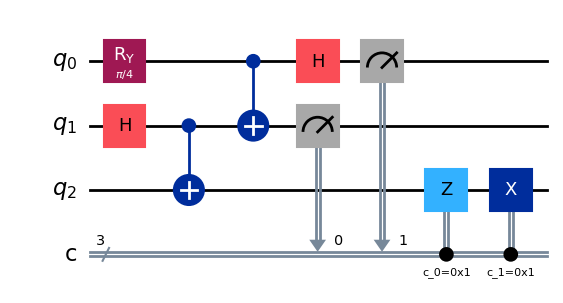

In [52]:
teleport_source = source.compose(teleport)
teleport_source.draw("mpl")

In [53]:
# run job source 
source.measure_all()
counts_source = aer_backend.run(source, shots=4000).result().get_counts()

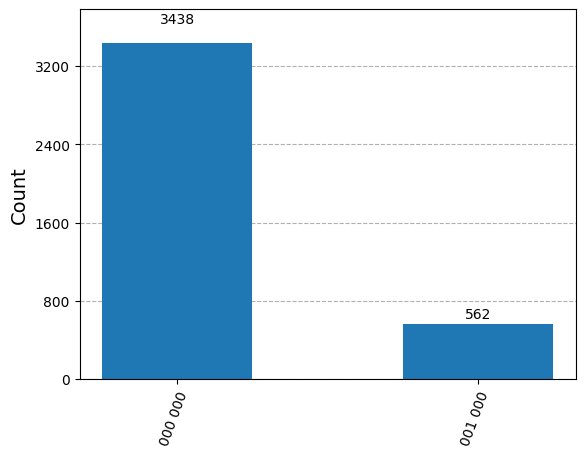

In [54]:
plot_histogram(counts_source)

## Teleportation on a real quantum computer

In [55]:
# pm = generate_preset_pass_manager(backend=real_backend,optimization_level=3)
# isa_teleport_source = pm.run(teleport_source)

In [ ]:
# run teleport source on ibmq backend
# job_teleport_source = real_backend.run(isa_teleport_source, dynamic=True)
# job_teleport_source

In [ ]:
# Retrieve your results as soon as the job is finished

# counts_teleport_source = service.job("csy1a48yn5c0008bx5p0").result().get_counts()
# counts_teleport_source

In [ ]:
# plot_histogram(counts_teleport_source)

In [ ]:
# bobs_counts = marginal_counts(counts_teleport_source, [qr.index(b)])
# plot_histogram(bobs_counts)